## В данном ноутбуке рассматриваются некоторые возможности библиотеки LangChain и взаимодействие с векторными базами Faiss.
- Варианты разбивки текста на фрагменты (чанки).
- Создание и использование векторных баз Faiss.
- Добавление фрагментов текста и документов к векторной базе.
- Сохранение и загрузка ранее сохраненных векторных баз.
- Слияние (объединение) векторных баз.
- Использование ретриверов при взаимодействии с векторными базами.
- Модель ChatOpenAI с использованием ретривера


# Подготовка к созданию индексных (векторных) баз

In [ ]:
# Устанавливаем необходимые библиотеки
!pip install -q openai==1.57.0 langchain==0.3.9 langchain_core==0.3.21 langchain_community==0.3.9 \
langchain-openai==0.2.11 faiss-cpu==1.9.0.post1 tiktoken==0.8.0

In [ ]:
# импортируем необходимые библиотеки
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain.text_splitter import (MarkdownHeaderTextSplitter,
                                     RecursiveCharacterTextSplitter,
                                     CharacterTextSplitter)
import os
import re
import requests
import textwrap
import openai
import tiktoken
from glob import glob
import matplotlib.pyplot as plt
from google.colab import userdata, drive


# Получение ключа API OpenAI из секретов Колаба и установка как переменную окружения
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")


In [ ]:
# Служебные функции

# функция для загрузки документа Docx по ссылке из гугл драйв
def download_google_doc(url: str) -> str:
    # Извлекаем ID документа из URL
    match_ = re.search(r'/document/d/([a-zA-Z0-9-_]+)', url)
    if not match_:
        raise ValueError("Invalid Google Docs URL")
    doc_id = match_.group(1)
    download_url = f'https://docs.google.com/document/d/{doc_id}/export?format=txt'
    response = requests.get(download_url, stream=True)
    if response.status_code != 200:
        raise RuntimeError("Failed to download the document")
    return response.text


# Функция для форматирования текста по абзацам
def format_text(text, width=120):
    # Разделяем текст на абзацы
    paragraphs = text.split('\n')
    # Форматируем каждый абзац отдельно
    formatted_paragraphs = []
    for paragraph in paragraphs:
        # Используем textwrap.fill для форматирования абзаца, чтобы длина строки не превышала width
        formatted_paragraph = textwrap.fill(paragraph, width)
        formatted_paragraphs.append(formatted_paragraph)
    # Объединяем абзацы с символом новой строки
    return '\n'.join(formatted_paragraphs)


# Функция возвращает количество токенов в строке в зависимости от используемой модели
def num_tokens_from_string(string: str, model='gpt-4o-mini') -> int:
    # Получаем имя кодировки для указанной модели
    encoding_name = tiktoken.encoding_for_model(model).name
    # Получаем объект кодировки на основе имени кодировки
    encoding = tiktoken.get_encoding(encoding_name)
    # Кодируем строку и вычисляем количество токенов
    num_tokens = len(encoding.encode(string))
    # Возвращаем количество токенов
    return num_tokens


# Построение гистограммы распределения количества токенов по чанкам
def create_histogram(chunks):
    print("\nОбщее количество чанков: ", len(chunks))
    # Подсчет токенов для каждого чанка
    try: # для формата чанков LangChain Document
        chunk_token_counts = [num_tokens_from_string(chunk.page_content) for chunk in chunks]
    except: # для текстового формата чанков
        chunk_token_counts = [num_tokens_from_string(chunk) for chunk in chunks]
    # Строим гистограмму
    plt.figure(figsize=(7, 4)) # размер
    plt.hist(chunk_token_counts, bins=10, alpha=0.5, label='Чанки')
    plt.title('Распределение к-ва токенов по чанкам')  # Заголовок графика
    plt.xlabel('К-во токенов в чанке')  # Подпись оси X
    plt.ylabel('К-во чанков')  # Подпись оси Y
    plt.show()  # Отображаем график

In [ ]:
# Ссылки на базы знаний, которые будем использовать:

# База знаний компании Postoplan - часть 1 (с разбивкой MarkDown)
url_base1_postoplan = 'https://docs.google.com/document/d/13WKOhsA2H7nWjZkuy2wDJ2oDv2Y-m8yt'
# База знаний компании Postoplan - часть 2 (с разбивкой MarkDown)
url_base2_postoplan = 'https://docs.google.com/document/d/1UDNfJvWGPQRz97Xnzf-y3AcEWtFJFT7U'

# База знаний компании Simble - часть 1 (без разбивки MarkDown)
url_base1_simble = 'https://docs.google.com/document/d/1Z7eZLIPG9URgOFz-yqtJAup-WXhKFIiF'
# База знаний компании Simble - часть 2 (без разбивки MarkDown)
url_base2_simble = 'https://docs.google.com/document/d/1qxJXwHtYNxx6ecf35zhqFYBxSjoA5Mhr'

# Повторим варианты разбивки текстов на чанки из прошедших занятий

- LangChain — это фреймворк, который упрощает создание приложений с использованием языковых моделей. Он предоставляет набор инструментов, модулей и интерфейсов для интеграции языковых моделей в сложные приложения, такие как чат-боты, системы поиска, автоматизация задач, генерация контента и многое другое.

- В LangChain объект Document представляет собой основную структуру для работы с текстом и метаданными. Когда речь идет о чанках в формате Document, это означает разбиение длинного текста на несколько экземпляров объектов Document, каждый из которых содержит фрагмент текста и соответствующие метаданные.

- Объект Document состоит из двух ключевых компонентов:

    - page_content – текстовая часть документа, содержащая сам текст.
    - metadata – словарь, хранящий метаданные, такие как источник текста, номер страницы, раздел документа и т.д.

- Пример чанка в LangChain Document:
```python
exemple_1 = Document(
    page_content = "The weather forecast for tomorrow is cloudy and overcast, with a high of 62 degrees.",
    metadata={"source": "news", "start_index": 5}
)
```

MarkdownHeaderTextSplitter — это компонент из библиотеки LangChain, используемый для разбивки текста в формате Markdown на чанки (объекты Document). Основная идея заключается в использовании заголовков Markdown (например, #, ##, ###) для определения границ этих чанков.

Параметр strip_headers в MarkdownHeaderTextSplitter:
- Если strip_headers = True:
    - Заголовки удаляются из текста чанков (page_content).
    - Но информация о заголовках (текст заголовка, уровень, тип) сохраняется в метаданных.

- Если strip_headers = False:
    - Заголовки остаются в тексте чанков (page_content).
    - Метаданные также содержат информацию о заголовках.

В MarkdownHeaderTextSplitter заголовки сохраняются в метаданных, независимо от того, используется ли опция strip_headers.


page_content: 
## Что еще дает Postoplan?
1. Никакого стресса: POSTOPLAN уведомит вас о состоянии каждого запланированного поста или сообщения. Вы сразу узнаете о загрузке новой публикации.
Экономия времени: отложенный постинг помогает оптимизировать рабочий процесс и освободить больше драгоценного времени на другие задачи.
2. Автоматизация SMM: периодически проводите акции и розыгрыши в аккаунтах? Настройте автопостинг и не беспокойтесь, что забудете сообщить своим подписчикам важную информацию.
3. Банк идей для постов: в POSTOPLAN вы найдеты шаблоны публикаций и инфоповодов на каждый день. Создание контента еще никогда не было таким быстрым!

metadata: 
{'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Что еще дает Postoplan?'}

Общее количество чанков:  107


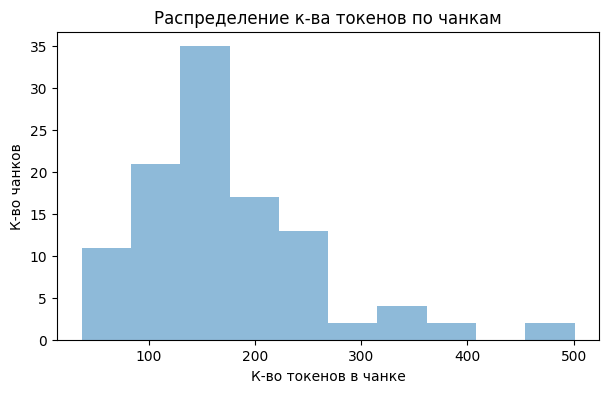

In [ ]:
# (MarkdownHeaderTextSplitter)
# Формируем чанки в формат LangChain Document из текста с Markdown разметкой
def split_markdown_text(markdown_text,
                        strip_headers=False): # НЕ удалять заголовки под '#..' из page_content
    # Удалить пустые строки и лишние пробелы
    markdown_text = re.sub(r' {1,}', ' ', re.sub(r'\n\s*\n', '\n', markdown_text))
    # Определяем заголовки, по которым будем разбивать текст
    headers_to_split_on = [("#", "Header 1"),   # Заголовок первого уровня
                           ("##", "Header 2"),  # Заголовок второго уровня
                           ("###", "Header 3")] # Заголовок третьего уровня
    # Создаем экземпляр MarkdownHeaderTextSplitter с заданными заголовками
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on,
                                                   strip_headers=strip_headers)
    # Разбиваем текст на чанки в формат LangChain Document
    chunks = markdown_splitter.split_text(markdown_text)
    return chunks # Возвращаем список чанков в формате LangChain Document


# Скачиваем базу знаний (.docx с разбивкой Markdown) по ссылке
text_md_content = download_google_doc(url_base1_postoplan)
# Пример создания чанков
chunks_md = split_markdown_text(text_md_content)
# Пример одного чанка
print(f'\npage_content: \n{chunks_md[5].page_content}')
print(f'\nmetadata: \n{chunks_md[5].metadata}')
# Гистограмма распределения количества токенов по чанкам
create_histogram(chunks_md)

RecursiveCharacterTextSplitter — это инструмент из библиотеки LangChain, предназначенный для разбивки больших текстов на фрагменты (чанки) по количеству символов.

Перекрытие чанков (параметр chunk_overlap) добавляет некоторое количество символов из конца предыдущего чанка в начало следующего.
Это полезно для сохранения контекста при обработке текста.

Вы можете указать список предпочтительных разделителей (параметр separators=["\n\n", "\n", " "]), чтобы контролировать, где будет происходить разбиение.


page_content: 
﻿КАСКО в Simble теперь можно приобрести в рассрочку с картой Свобода\n\nТеперь КАСКО в Simble можно приобрести в
рассрочку с картой Свобода от Банка Хоум Кредит. Карта Свобода предоставляет возможность делать покупки в рассрочку до
12 месяцев у партнеров или до 51 дня в любых магазинах. С помощью карты Свобода можно оформить КАСКО на короткий срок в
приложении Simble. Узнать подробнее об условиях предложения и оформить карту Свобода можно [здесь](ссылка). Simble –
КАСКО на короткий период\n\nSimble предлагает страховку на короткий период, которая позволяет застраховать автомобиль на
1 час поездки, 100 км пути или на время парковки. Стоимость страховки начинается от 14 ₽ в день. Также в приложении
Simble можно оформить КАСКО на год поездки или парковку. Страховка на парковку предлагается по часам, начиная от 13 ₽ в
час. Страховка на поездку предлагается по часам, начиная от 95 ₽ в час, или на любое количество километров, начиная от
175 ₽ за 100 км. Simble также предлагае

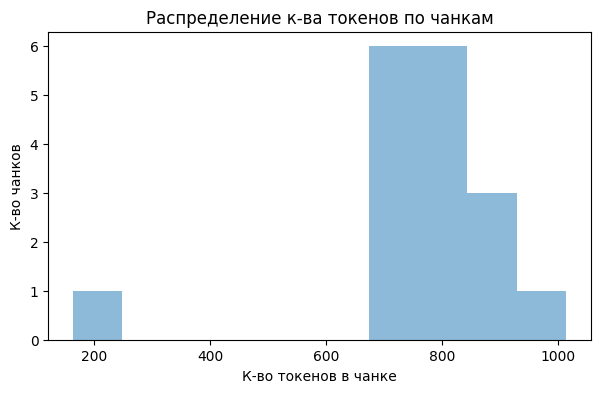

In [ ]:
# (RecursiveCharacterTextSplitter)
# Формируем чанки в формат LangChain Document из текста по количеству символов
def split_hard_text(text: str,
                    chunk_size=3000,  # Ограничение к-ва символов в чанке
                    chunk_overlap=100): # к-во символов перекрытия в чанке
    # Удалить пустые строки и лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    # Создаем экземпляр RecursiveCharacterTextSplitter с заданными парамаетрами
    text_splitter = RecursiveCharacterTextSplitter(
                            chunk_size=chunk_size,
                            chunk_overlap=chunk_overlap,
                            # separators=["\n\n", "\n", " "]  # Приоритет разделителей
                            )
    # Разбиваем текст на чанки с помощью созданного сплиттера
    chunks = text_splitter.split_text(text)
    # Преобразование фрагментов текста в формат LangChain Document (без метаданных)
    chunks = [Document(page_content=chunk) for chunk in chunks]
    return chunks # Возвращаем список чанков в формате LangChain Document


# Скачиваем базу знаний (без разбивки Markdown) по ссылке
text_content = download_google_doc(url_base1_simble)
# Пример создания чанков
chunks = split_hard_text(text_content)
# Пример одного чанка
print(f'\npage_content: \n{format_text(chunks[0].page_content)}')
# Поле metedata не использовалось
# Гистограмма распределения количества токенов по чанкам
create_histogram(chunks)

CharacterTextSplitter — это простой текстовый разделитель в LangChain, предназначенный для разбиения текста на фрагменты (чанки) на основе заданного разделителя и максимального размера чанков. Этот инструмент прост и удобен, если текст структурирован и вы хотите контролировать разбиение с использованием фиксированного разделителя.

Обратите внимание, что чанки, при использовании CharacterTextSplitter - это просто список строк, а не LangChain Document

In [ ]:
# (CharacterTextSplitter) Формируем чанки из текста по количеству символов
def split_text(text: str,
               chunk_size=2000,    # Ограничение к-ва символов в чанке
               chunk_overlap=200): # к-во символов перекрытия в чанке
    # Удалить пустые строки и лишние пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    # Создаем экземпляр CharacterTextSplitter с заданными парамаетрами
    splitter = CharacterTextSplitter(chunk_size=chunk_size,
                                     chunk_overlap=chunk_overlap,
                                     separator=" ") # разделитель по словам
    return splitter.split_text(text) # список текстовых чанков

# Добавление текстов и врагментов Langchain Documents к существующей БЗ

In [ ]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексные базы
db_md = FAISS.from_documents(chunks_md, embeddings)
db = FAISS.from_documents(chunks, embeddings)

Пример, как добавить к существующей БЗ 2 чанка с метаданными:

In [ ]:
ids = db.add_texts(["Пример текста 1", "Пример текста 2"],
                   metadatas=[{"author": "user1"}, {"author": "user2"}])

# в итоге получаем ID добавленных чанков:
ids

['dc712a24-73ff-454c-a1c6-3d0ae51f28b2',
 'e3205887-9935-4fff-9db8-e0b4c028eccb']

Что делает метод:
Метод предназначен для добавления документов в хранилище векторов
- Извлекает текст и метаданные из каждого документа в предоставленном списке documents.
- Передает эти тексты (и метаданные) в другой метод, который затем преобразует тексты в векторные представления и добавляет их в хранилище векторов.
- Возвращает идентификаторы добавленных текстов.

In [ ]:
# Предположим, у нас есть некоторый список документов следующего вида:
documents = [
    Document(page_content="Текст документа 1", metadata={"author": "Автор 1"}),
    Document(page_content="Текст документа 2", metadata={"author": "Автор 2"})
]
# Используем метод add_documents для добавления документов в хранилище
added_ids = db_md.add_documents(documents)

# Теперь added_ids содержит идентификаторы добавленных текстов
added_ids

['3e95bdef-baae-47d1-9afe-ccb9e8b349d9',
 'b1f1b4dd-5cbe-4623-bd88-909be3f68fd3']

# Поиск по векторному хранилищу

In [ ]:
# similarity_search
similar_documents = db_md.similarity_search("Интересные факты о маркетинге социальных сетей", k=3)

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content + f'\nMetedata: {doc.metadata}'
     for i, doc in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
# Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metedata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и
продвигайте свой контент'}

Отрывок документа № 2:
## Создаем выдающиеся возможности для маркетинга в соцсетях
Гибкие тарифные планы: платите только за подключенные аккаунты, без лишних расходов и переплат
2 крутых графических редактора: простой и с конструктором, а также библиотека с 2 млн. изображений
Постинг за раз в несколько аккаунтов: выбирайте контент и размещайте сразу везде — очень удобно и экономит время
Не только стандартные соцсети: есть Google My Bus

In [ ]:
# similarity_search_with_score
similar_documents = db_md.similarity_search_with_score("Интересные факты о маркетинге социальных сетей", k=3)

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content + f'\nMetedata: {doc.metadata}' + f'\nScore: {score}'
     for i, (doc, score) in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
# Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metedata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и
продвигайте свой контент'}
Score: 0.28809216618537903

Отрывок документа № 2:
## Создаем выдающиеся возможности для маркетинга в соцсетях
Гибкие тарифные планы: платите только за подключенные аккаунты, без лишних расходов и переплат
2 крутых графических редактора: простой и с конструктором, а также библиотека с 2 млн. изображений
Постинг за раз в несколько аккаунтов: выбирайте контент и размещайте сразу везде — очень удобно и экономит время
Не только стандартные 

# max_marginal_relevance_search

### Maximal Marginal Relevance

Метод поиска **"Maximal Marginal Relevance"** (MMR), или **"Максимальная Маргинальная Релевантность"**, – это подход к поиску, который стремится не только предоставить релевантные, но и разнообразные результаты пользователю. В отличие от традиционных методов поиска, которые фокусируются преимущественно на релевантности (соответствии между запросом пользователя и возможными результатами), MMR старается также уменьшить схожесть между собой выдаваемых документов, чтобы они были не только актуальными, но и максимально информативными и разнообразными.

**Как это работает простыми словами:**

- Релевантность: Метод ищет документы, которые как можно лучше соответствуют запросу пользователя.

- Разнообразие: Метод также старается убедиться, что предложенные документы максимально разные, чтобы пользователь мог получить информацию из разных источников или разных точек зрения.

**Пример:**
Представим, что у нас есть множество статей по медицине и пользователь ищет информацию о "гриппе". Стандартный поиск просто найдет самые релевантные статьи, возможно, все они будут из одного источника или говорить о одном и том же исследовании.

В случае с MMR:

- Шаг 1: Метод может предоставить статью, которая наиболее точно соответствует запросу (например, статья о последних исследованиях вакцин от гриппа).
- Шаг 2: Далее, вместо того чтобы предоставить другую статью, говорящую о том же исследовании, MMR может предложить статью о домашних методах предотвращения гриппа или о статистике заболеваемости гриппом в разных странах, чтобы расширить предоставляемую информацию и дать пользователю разные точки зрения или аспекты темы.

Таким образом, подход MMR позволяет не только найти наиболее подходящую информацию, но и представить пользователю разнообразные документы, чтобы обеспечить более широкий и полный обзор по запрашиваемой теме.

**Что делает метод max_marginal_relevance_search:**

Этот метод предназначен для поиска документов, которые не только релевантны запросу, но и максимально разнообразны между собой.

Осуществляет поиск документов, похожих на переданный запрос (query).
Из этих документов выбирает подмножество, используя алгоритм Maximal Marginal Relevance (MMR), который стремится оптимизировать не только схожесть с запросом, но и диверсификацию (разнообразие) между возвращаемыми документами.
 - k - количество возвращаемых документов. Чем больше k, тем более разнообразными будут результаты.

 - fetch_k - количество документов, которые изначально извлекаются для анализа алгоритмом MMR. Обычно больше, чем k.

 - lambda_mult - коэффициент, контролирующий баланс между релевантностью и разнообразием. Чем меньше значение, тем разнообразнее результаты.

Таким образом, варьируя эти параметры, можно гибко настраивать работу алгоритма MMR для достижения нужного баланса релевантности и разнообразия результатов поиска.

**Как использовать:**
Пример использования метода max_marginal_relevance_search может выглядеть следующим образом:



In [ ]:
# max_marginal_relevance_search
# найти документы, максимально релевантные и разнообразные для вашего запроса:
query = "Интересные факты о маркетинге социальных сетей"

# Используем метод max_marginal_relevance_search для поиска документов
selected_documents = db_md.max_marginal_relevance_search(
    query=query,
    k=3,             # хотим получить 3 докуменеа
    fetch_k=20,      # рассматриваем 20 документов для MMR
    lambda_mult=0.5, # балансируем между релевантностью и диверсификацией
)
# Перебираем список выбранных документов
for i, doc in enumerate(selected_documents):
    # Выводим информацию о каждом документе.
    print(f"Document {i + 1}:")
    print(f"Content: {format_text(doc.page_content)}")
    print(f"Metadata: {doc.metadata}")
    print("-"*30 + "\n")

Document 1:
Content: # Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metadata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент'}
------------------------------

Document 2:
Content: ### Сентябрь 2020
1. Пробный период Social Inbox
2. Владельцы статусов FREE смогут общаться с клиентами в Facebook и Twitter в течение 3 дней
3. Скачивание статистики
4. Добавлена возможность скачивания статистики в формате .png
5. Выбор периода статистики
6. Теперь можно выбрать, за какой период будет показана статистика
7. Разделение по категориям
8. Добавлена возможность разделять пос

# similarity_search_with_relevance_scores

Метод **similarity_search_with_relevance_scores** предназначен для поиска документов, наиболее похожих (или релевантных) на заданный текстовый запрос query.

Метод возвращает список документов и соответствующих им оценок схожести с запросом.
Оценка схожести находится в диапазоне [0, 1], где 0 указывает на полное несоответствие, а 1 - на полное совпадение.
Опциональный аргумент k задает количество документов, которые необходимо вернуть (по умолчанию, 4).
Опциональный аргумент score_threshold может быть использован для фильтрации результатов по порогу схожести.
Как использовать:

Пример использования методов может выглядеть следующим образом:

In [ ]:
# similarity_search_with_relevance_scores
query = "Интересные факты о маркетинге социальных сетей"

k = 3  # мы хотим получить до 3 результатов
score_threshold = 0.75  # мы хотим видеть только документы, релевантность которых не менее 0.75

results = db_md.similarity_search_with_relevance_scores(query, k,
                                                        score_threshold=score_threshold)

# Выведем результаты
for doc, similarity_score in results:
    print(f"Document: {format_text(doc.page_content)} \
            \nMetadata: {doc.metadata} \
            \nScore_threshold: {similarity_score}")
    print("-"*30 + "\n")

Document: # Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории             
Metadata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент'}             
Score_threshold: 0.7962880756835967
------------------------------

Document: ## Создаем выдающиеся возможности для маркетинга в соцсетях
Гибкие тарифные планы: платите только за подключенные аккаунты, без лишних расходов и переплат
2 крутых графических редактора: простой и с конструктором, а также библиотека с 2 млн. изображений
Постинг за раз в несколько аккаунтов: выбирайте контент и размещайте сразу везде — очень удобно 

# save_local: сохранение векторных баз Faiss локально

Метод **save_local** предназначен для сохранения векторного хранилища документов на диск. Он используется, чтобы вы могли сохранить текущее состояние вашего индекса FAISS и связанных с ним данных, чтобы впоследствии загрузить их обратно без необходимости пересоздавать хранилище с нуля.

- folder_path: Путь к папке, в которой вы хотите сохранить данные.
- index_name: Имя, которое будет использоваться для сохранённых файлов, чтобы вы могли их идентифицировать позже.
```python
db_index.save_local(folder_path=path, # путь к папке
                      index_name=index_name)  # имя для индексной базы
```










In [ ]:
# Подключаем ГуглДиск для работы с файлами
drive.mount('/content/drive')

# Формируем основные пути на ГуглДиске для работы с файлами
path_db_index_md = '/content/drive/MyDrive/data/db_index_md/'     # для векторных баз из Markdown документов
path_db_index_text = '/content/drive/MyDrive/data/db_index_text/' # для векторных баз из документов без MD разбивки

# Создаем папки. Если папки уже созданы ранее, то данные сохранятся
for folder in [path_db_index_md, path_db_index_text]:
    os.makedirs(folder, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Создание индексной (векторной) базы из чанков в формате LangChain Document и сохранение на диск
def create_db_index_from_documents_save(chunks_documents,
                                        index_name, # имя для индексной базы
                                        path):  # путь к папке
    # Создаем индексную базу с использованием FAISS ---------------------------------
    db_index = FAISS.from_documents(chunks_documents,
                                    OpenAIEmbeddings())
    # сохраняем индексную базу ------------------------------------------------------
    db_index.save_local(folder_path=path, # путь к папке (path)
                        index_name=index_name)  # имя для индексной базы (index_name)
    # --------------------------------------------------------------------------------
    return db_index


# Создаем индексные (векторные) базы и сохраняем на ГуглДиск

# Базы знаний Postoplan
for i, url in enumerate([url_base1_postoplan, url_base2_postoplan]):
    # Скачиваем базу знаний (с разбивкой Markdown) по ссылке
    text_md_content = download_google_doc(url)
    # Создание чанков из Markdown документа
    chunks_md = split_markdown_text(text_md_content)
    # Создание векторной базы и сохранение на диск
    create_db_index_from_documents_save(chunks_md,
                                        f'postoplan_{i+1}', # имя для индексной базы
                                        path_db_index_md)  # ранее созданный путь на ГуглДиске


# Базы знаний Simble
for i, url in enumerate([url_base1_simble, url_base2_simble]):
    # Скачиваем базу знаний по ссылке
    text_content = download_google_doc(url)
    # Создание чанков из документа
    chunks = split_hard_text(text_content)
    # Создание векторной базы и сохранение на диск
    create_db_index_from_documents_save(chunks,
                                        f'simble_{i+1}', # имя для индексной базы
                                        path_db_index_text)  # ранее созданный путь на ГуглДиске

In [ ]:
# Проверим файлы на ГуглДиске:
!ls /content/drive/MyDrive/data/db_index_md/ /content/drive/MyDrive/data/db_index_text/

/content/drive/MyDrive/data/db_index_md/:
postoplan_1.faiss  postoplan_1.pkl  postoplan_2.faiss  postoplan_2.pkl

/content/drive/MyDrive/data/db_index_text/:
simble_1.faiss	simble_1.pkl  simble_2.faiss  simble_2.pkl


Теперь, в указанных директориях на ГуглДиске, вы найдете по два файла для каждой векторной бызы с расширением .faiss и .pkl.
В последующем вы можете использовать эти файлы для восстановления состояния вашей векторной БЗ без необходимости создания эмбедингов (переиндексации) всех данных снова.

# load_local: загрузка сохраненной векторной базы

### Загрузка ранее сохраненных векторной базы FAISS и объединение из нескольких в одну

```python
db_index = FAISS.load_local(
        allow_dangerous_deserialization=True,
        embeddings=OpenAIEmbeddings(),
        folder_path=folder_path, # путь к сохраненной векторной базе
        index_name=index_name)  # имя сохраненной векторной базы


# Дополнительно, слияние баз в одну db_index_1
# База db_index_2 объединится с базой db_index_1
# db_index_1 станет объединенной базой

db_index_1.merge_from(db_index_2)
# --------------------------------------------------
```

In [ ]:
# Загрузка векторной базы с диска
def load_db_vector(folder_path_db_index,  # путь к сохраненной векторной базе
                   index_name):           # имя сохраненной векторной базы
    return FAISS.load_local(
                allow_dangerous_deserialization=True, # Разрешает потенциально небезопасную десериализацию
                embeddings=OpenAIEmbeddings(),  # Указывает векторные представления
                folder_path=folder_path_db_index, # путь к сохраненной векторной базе
                index_name=index_name) # имя сохраненной векторной базы


# Загружаем ранее сохраненные на ГуглДиске векторные базы из папки и объединяем в одну
def get_dbs_vector(path_dbs):
    # Для объединения нескольких баз в цикле будем присоединять существующие базы к новой (пустой)
    # Создание пустой векторной базы -----------------------------------------------------
    db_index_new = FAISS.from_documents([Document(page_content='', metadata={})],
                                        OpenAIEmbeddings())  # FAISS.from_documents
    # или для текстового формата чанков:
    # db_index_new = FAISS.from_texts([''], OpenAIEmbeddings())  # FAISS.from_texts
    # ------------------------------------------------------------------------------------
    # пробегаем по всем файлам векторных баз в нашей папке
    for file in glob(f'{path_dbs}*.faiss'):
        index_name = file.split('/')[-1].split('.')[0]  # Имя векторной базы на диске
        # Загрузка ранее сохраненной векторной базы
        db_index_loaded = load_db_vector(path_dbs, index_name)
        print(f'Векторная база: "{index_name}" загружена')
        # Слияние баз в одну db_index_new ------------------
        db_index_new.merge_from(db_index_loaded)
        # --------------------------------------------------
    return db_index_new


# Создаем объединенную векторную базу Postoplan
db_postoplan_merged = get_dbs_vector(path_db_index_md)
# Создаем объединенную векторную базу Simble
db_simble_merged = get_dbs_vector(path_db_index_text)

Векторная база: "postoplan_1" загружена
Векторная база: "postoplan_2" загружена
Векторная база: "simble_1" загружена
Векторная база: "simble_2" загружена


### Проверим работу объединенной векторной базы

In [ ]:
# similarity_search_with_score
# Используем векторную базу: db_postoplan_merged

similar_documents = db_postoplan_merged.similarity_search_with_score(
    "Интересные факты о маркетинге социальных сетей", k=3)

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content + f'\nMetedata: {doc.metadata}' + f'\nScore: {score}'
     for i, (doc, score) in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
# Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metedata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и
продвигайте свой контент'}
Score: 0.2880343198776245

Отрывок документа № 2:
## На 70% больше охватов - чем отложенный постинг лучше обычного
Основная задача бизнеса в соцсетях - постоянно быть на связи с аудиторией, размещая полезный контент. Появляться в ленте
подписчиков можно планомерно, по мере написания публикаций, а можно загрузить все посты заранее. О преимуществах второго
варианта как раз и пойдет речь в этой статье.
Metedata: {'Header 1': 'Блог', 'Heade

In [ ]:
# similarity_search_with_score
# Используем векторную базу: db_simble_merged

similar_documents = db_simble_merged.similarity_search_with_score(
    "КАСКО на короткий срок", k=3)

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content[:1500] + f'\nScore: {score}'
     for i, (doc, score) in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
﻿КАСКО в Simble теперь можно приобрести в рассрочку с картой Свобода\n\nТеперь КАСКО в Simble можно приобрести в
рассрочку с картой Свобода от Банка Хоум Кредит. Карта Свобода предоставляет возможность делать покупки в рассрочку до
12 месяцев у партнеров или до 51 дня в любых магазинах. С помощью карты Свобода можно оформить КАСКО на короткий срок в
приложении Simble. Узнать подробнее об условиях предложения и оформить карту Свобода можно [здесь](ссылка). Simble –
КАСКО на короткий период\n\nSimble предлагает страховку на короткий период, которая позволяет застраховать автомобиль на
1 час поездки, 100 км пути или на время парковки. Стоимость страховки начинается от 14 ₽ в день. Также в приложении
Simble можно оформить КАСКО на год поездки или парковку. Страховка на парковку предлагается по часам, начиная от 13 ₽ в
час. Страховка на поездку предлагается по часам, начиная от 95 ₽ в час, или на любое количество километров, начиная от
175 ₽ за 100 км. Simble также п

# Использование векторных баз в моделях OpenAI

In [ ]:
# Функция запроса и ответа от OpenAI с поиском по векторной базе данных
def generate_answer(query,    # запрос пользователя
                    db_index, # векторная база знаний
                    k=5,      # используемое к-во чанков
                    verbose=True, # выводить ли на экран выбранные чанки
                    model='gpt-4o-mini',
                    temp=0.1):
    # Поиск чанков по векторной базе данных
    similar_documents = db_index.similarity_search(query, k=k)
    # Формирование текстового контента из выбранных чанков для модели
    message_content = re.sub(r'\n{2}', ' ', '\n '.join(
        [f'Отрывок документа № {i+1}:\n' + doc.page_content
        for i, doc in enumerate(similar_documents)]))
    if verbose:
        print(message_content) # печать на экран выбранных чанков

    messages = [{"role": "system", "content":
                 f'Ответь на вопрос пользователя на основании информации из базы знаний: \n{message_content}'},
                {"role": "user", "content":
                 f'Вопрос пользователя: {query}'}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp)
    return response.choices[0].message.content

In [ ]:
query = "Интересные факты о маркетинге социальных сетей"

# Используем векторную базу: db_postoplan_merged
answer = generate_answer(query, db_postoplan_merged, k=5, verbose=False)
print('Ответ модели:\n')
print(format_text(answer))

Ответ модели:

Вот несколько интересных фактов о маркетинге в социальных сетях:

1. **Увеличение охвата**: Использование отложенного постинга может увеличить охват публикаций на 70% по сравнению с
обычным размещением контента. Это позволяет бизнесам более эффективно взаимодействовать с аудиторией.

2. **Экономия времени**: 76% пользователей сервиса POSTOPLAN отметили, что смогли сократить время работы в соцсетях
более чем на 4 часа в неделю, что позволяет сосредоточиться на других важных задачах.

3. **Рост клиентской базы**: 15% пользователей сервиса уже в первые месяцы работы отметили увеличение количества
клиентов, что подчеркивает эффективность использования инструментов для планирования контента.

4. **Увеличение охвата и аудитории**: 55% пользователей отметили рост охвата постов и увеличение аудитории, что
свидетельствует о том, что правильное планирование контента может значительно повысить видимость бренда.

5. **Гибкость тарифов**: Сервисы, такие как POSTOPLAN, предлагают гибк

# as_retriever

- В LangChain, ретриверы (retrievers) — это компоненты, предназначенные для извлечения релевантной информации из большого набора данных или документов. Они используются в системах вопросов и ответов, обеспечивая доступ к нужной информации для языковой модели.

- Что делает as_retriever?
Метод as_retriever упрощает использование различных хранилищ данных, преобразуя их в объект ретривера. Этот объект можно использовать для поиска и извлечения информации, необходимой языковой модели. Например, если вы работаете с базой данных, файлом, или векторным хранилищем (например, FAISS), метод as_retriever позволяет вам использовать их как унифицированный интерфейс для поиска данных.

In [ ]:
# "similarity"
# Используем векторную базу: db_postoplan_merged

retriever = db_postoplan_merged.as_retriever(search_type="similarity",
                                             search_kwargs={"k": 2})

similar_documents = retriever.invoke("Интересные факты о маркетинге социальных сетей")

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content + f'\nMetedata: {doc.metadata}'
     for i, doc in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
# Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metedata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и
продвигайте свой контент'}

Отрывок документа № 2:
## На 70% больше охватов - чем отложенный постинг лучше обычного
Основная задача бизнеса в соцсетях - постоянно быть на связи с аудиторией, размещая полезный контент. Появляться в ленте
подписчиков можно планомерно, по мере написания публикаций, а можно загрузить все посты заранее. О преимуществах второго
варианта как раз и пойдет речь в этой статье.
Metedata: {'Header 1': 'Блог', 'Header 2': 'На 70% больше охват

In [ ]:
# "mmr"
# Используем векторную базу: db_postoplan_merged

retriever = db_postoplan_merged.as_retriever(
                                    search_type="mmr",
                                    search_kwargs={'k': 3,
                                                   'lambda_mult': 0.5})
"""
Параметр *lambda_mult*  представляет собой число в диапазоне от 0 до 1, которое определяет уровень
разнообразия среди результатов поиска. Значение **lambda_mult 0** соответствует **максимальному
разнообразию**, в то время как значение **1** соответствует **минимальному разнообразию** в результатах​
- В контексте поиска с максимальной маргинальной релевантностью lambda_mult помогает оптимизировать
баланс между сходством с запросом и разнообразием среди выбранных документов. Это означает, что более
низкое значение lambda_mult может привести к более разнообразным результатам, возможно, менее релевантным
для запроса, в то время как более высокое значение lambda_mult может привести к результатам, более
релевантным для запроса, но менее разнообразным​
- В нескольких случаях, в различных реализациях алгоритмов поиска, очевидно, что lambda_mult служит
важным параметром для управления компромиссом между релевантностью и разнообразием во время поиска,
тем самым влияя на тип результатов, возвращаемых алгоритмом MMR​.
"""

similar_documents = retriever.invoke("Интересные факты о маркетинге социальных сетей")

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content + f'\nMetedata: {doc.metadata}'
     for i, doc in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
# Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metedata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и
продвигайте свой контент'}

Отрывок документа № 2:
### Сентябрь 2020
1. Пробный период Social Inbox
2. Владельцы статусов FREE смогут общаться с клиентами в Facebook и Twitter в течение 3 дней
3. Скачивание статистики
4. Добавлена возможность скачивания статистики в формате .png
5. Выбор периода статистики
6. Теперь можно выбрать, за какой период будет показана статистика
7. Разделение по категориям
8. Добавлена возможность разделять посты по категориям
9. Импорт

In [ ]:
# "similarity_score_threshold"
# Используем векторную базу: db_postoplan_merged

retriever = db_postoplan_merged.as_retriever(
                search_type="similarity_score_threshold",
                search_kwargs={"score_threshold": 0.79})

similar_documents = retriever.invoke("Интересные факты о маркетинге социальных сетей")

message_content = re.sub(r'\n{2}', ' ', '\n '.join(
    [f'\nОтрывок документа № {i+1}:\n' + doc.page_content + f'\nMetedata: {doc.metadata}'
     for i, doc in enumerate(similar_documents)]))
print(format_text(message_content))


Отрывок документа № 1:
# Пусть соцсети работают на вас
## Соцсети на автопилоте — создавайте, планируйте и продвигайте свой контент
POSTOPLAN отмечен наградами, ему доверяют 50 000+ специалистов и компаний из 147 стран
76% уменьшили время работы в соцсетях более, чем на 4 часа в неделю
15% увеличили количество клиентов уже в первые месяцы работы с сервисом
55% отметили увеличение охвата постов и рост аудитории
Metedata: {'Header 1': 'Пусть соцсети работают на вас', 'Header 2': 'Соцсети на автопилоте — создавайте, планируйте и
продвигайте свой контент'}

Отрывок документа № 2:
## На 70% больше охватов - чем отложенный постинг лучше обычного
Основная задача бизнеса в соцсетях - постоянно быть на связи с аудиторией, размещая полезный контент. Появляться в ленте
подписчиков можно планомерно, по мере написания публикаций, а можно загрузить все посты заранее. О преимуществах второго
варианта как раз и пойдет речь в этой статье.
Metedata: {'Header 1': 'Блог', 'Header 2': 'На 70% больше охват

## ChatOpenAI с использованием ретривера

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Инициализация языковой модели OpenAI
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.1)

# Создание объекта `retriever` для поиска по базе данных `db_postoplan_merged`
# с использованием метода поиска по схожести (similarity) и выборкой из 3 результатов
retriever = db_postoplan_merged.as_retriever(search_type="similarity",
                                             search_kwargs={"k": 3})

# Определение системного промпта для цепочки обработки
# Включает в себя обязательный шаблон с переменной `{context}`
system_prompt = """
Используй отрезки текста для ответа на вопрос.
Context: {context}"""  # Context: {context} - обязателен

# Создание шаблона промпта
prompt = ChatPromptTemplate.from_messages(
                        [("system", system_prompt),
                         ("human", "{input}")]
                        )

# Создание цепочки для обработки запросов (retrieval chain)
chain = create_retrieval_chain(
        retriever,  # Ретривер для извлечения релевантного контекста из векторной базы данных
        create_stuff_documents_chain(llm, prompt))  # Логика генерации ответа на основе модели `llm` и шаблона `prompt`

In [ ]:
query = "Интересные факты о маркетинге социальных сетей"
ans = chain.invoke({"input": query})

print('Ответ модели:\n')
print(format_text(ans['answer']), '\n')
# print('Выбранные чанки:\n')
# ans['context']

Ответ модели:

Вот несколько интересных фактов о маркетинге в социальных сетях:

1. **Увеличение охвата**: Использование отложенного постинга может привести к увеличению охвата на 70% по сравнению с
обычным размещением постов.

2. **Экономия времени**: 76% пользователей сервиса POSTOPLAN уменьшили время работы в соцсетях более чем на 4 часа в
неделю, что позволяет сосредоточиться на других важных аспектах бизнеса.

3. **Рост клиентской базы**: 15% специалистов и компаний, использующих POSTOPLAN, отметили увеличение количества
клиентов уже в первые месяцы работы с сервисом.

4. **Увеличение охвата постов**: 55% пользователей отметили рост охвата своих постов и увеличение аудитории.

5. **Гибкие тарифные планы**: Сервисы для управления соцсетями, такие как POSTOPLAN, предлагают гибкие тарифные планы,
позволяя платить только за подключенные аккаунты без лишних расходов.

6. **Командная работа**: В таких сервисах нет ограничений по количеству пользователей, что позволяет добавлять коллег и

In [ ]:
# Обернем в функцию
# Создание цепочки модели с использованием ретривера для поиска по векторной базе данных
def create_model_chain(db_index, # векторная база знаний
                       k=3,      # используемое к-во чанков
                       model='gpt-4o-mini',
                       temp=0.1):
    llm = ChatOpenAI(model=model, temperature=temp)
    retriever = db_index.as_retriever(search_type="similarity",
                                      search_kwargs={"k": k})
    system_prompt = """Ответь на вопрос пользователя используя отрезки текста.
    Context: {context}"""
    prompt = ChatPromptTemplate.from_messages(
                                [("system", system_prompt),
                                 ("human", "{input}")])
    return create_retrieval_chain(retriever,
                                  create_stuff_documents_chain(llm, prompt))


# ---------------------------------------------------------
# Используем c векторной базой данных `db_postoplan_merged`
new_chain = create_model_chain(db_postoplan_merged)

In [ ]:
query = "Интересные факты о маркетинге социальных сетей"
ans = new_chain.invoke({"input": query})

print('Ответ модели:\n')
print(format_text(ans['answer']), '\n')

Ответ модели:

Вот несколько интересных фактов о маркетинге в социальных сетях:

1. **Уменьшение времени работы**: 76% пользователей сервиса POSTOPLAN уменьшили время работы в соцсетях более чем на 4
часа в неделю.

2. **Увеличение клиентов**: 15% специалистов отметили увеличение количества клиентов уже в первые месяцы работы с
сервисом.

3. **Рост охвата**: 55% пользователей отметили увеличение охвата постов и рост аудитории.

4. **Преимущества отложенного постинга**: Отложенный постинг может обеспечить на 70% больше охватов по сравнению с
обычным размещением публикаций.

5. **Гибкие тарифные планы**: Сервисы, такие как POSTOPLAN, предлагают гибкие тарифные планы, позволяя платить только за
подключенные аккаунты без лишних расходов.

6. **Массовое планирование**: Возможность массового планирования и автопостинга позволяет составлять расписание для
загрузки контента на месяцы вперед.

Эти факты подчеркивают эффективность и преимущества использования социальных сетей для бизнеса. 

